In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys

sys.path.append(os.path.abspath("../models"))
sys.path.append(os.path.abspath("../preprocessing"))
sys.path.append(os.path.abspath("../features"))
sys.path.append(os.path.abspath("../signals"))
sys.path.append(os.path.abspath("../data"))

from preprocessing import apply_pca
from sklearn.svm import SVC
from classification import evaluate_single_fold, run_experiment
from dataset import create_labeled_dataset, get_kfold_splits
from sklearn.metrics import accuracy_score, confusion_matrix


In [53]:
f0 = 5
df = 0.1
f1 = [f0 + df*i for i in range(0,15,1)]
dfreq = [df*i for i in range(0,15,1)]

npoints = 5
nperiods = 4

noise = 0
samples = 100

In [54]:
all_results = []
for i, freq in enumerate(tqdm(f1)):
    results = []
    X, y = create_labeled_dataset(
        [(0, 'sine', {'args': [f0, noise, npoints, nperiods]}),
         (1, 'sine', {'args': [freq, noise, npoints, nperiods]})],
        n_samples_per_class=100
    )
    splits = get_kfold_splits(X, y, n_splits=5, stratified = False)

    results = run_experiment(X, y, splits)

    all_results.append({
        'df': round(freq- f0, 3),
        'raw': results['raw'],
        'pca': results['pca'],
        'features': results['features'],
        'features_pca': results['features_pca']
    })

100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


In [ ]:
#testing the signal creation

freq = 5.0
X, y = create_labeled_dataset(
        [(0, 'sine', {'args': [f0, noise, npoints, nperiods]}),
         (1, 'sine', {'args': [freq, noise, npoints, nperiods]})],
        n_samples_per_class=100
    )
X_test, y_test = create_labeled_dataset(
        [(0, 'sine', {'args': [f0, noise, npoints, nperiods]}),
         (1, 'sine', {'args': [freq, noise, npoints, nperiods]})],
        n_samples_per_class=100
    )
    

In [76]:

# esto confirma que si hay dataleakage.
model = SVC(probability=True)

model.fit(X,y)

pred = model.predict(X_test)
acc =  accuracy_score(y_test, pred)
acc



0.525

In [77]:
#esto significa que no hay un dataleakeage sino que toda la wea esta mala hjdsahjdsahjsa y que tengo que reducir la diferencia en frecuencia

In [57]:
records = []
for entry in all_results:
    df = entry["df"]
    for method in ["raw", "pca", "features", "features_pca"]:
        for auc in entry[method]:
            records.append({"Δf": df, "Method": method, "AUC": auc})

df_results = pd.DataFrame.from_records(records)

summary = (
    df_results
    .groupby(["Δf", "Method"])["AUC"]
    .agg(["median", "std"])
    .reset_index()
)

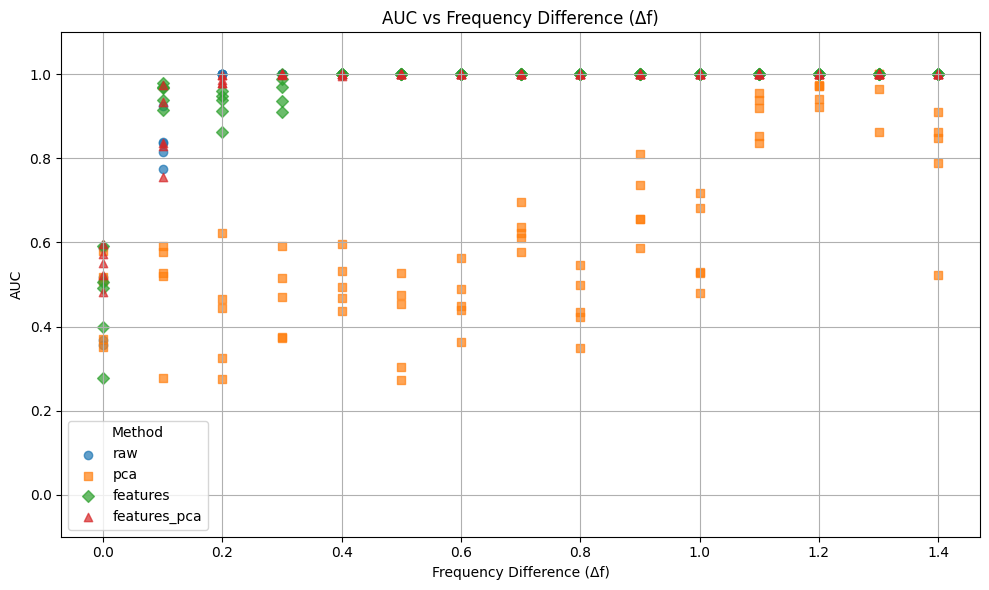

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define unique marker shapes per method
markers = {
    "raw": "o", 
    "pca": "s", 
    "features": "D", 
    "features_pca": "^"
}

plt.figure(figsize=(10, 6))

# Plot each point individually with the correct marker
for method, marker in markers.items():
    data = df_results[df_results["Method"] == method]
    plt.scatter(
        data["Δf"], data["AUC"],
        label=method,
        marker=marker,
        alpha=0.7  # optional: make overlapping points more readable
    )

plt.title("AUC vs Frequency Difference (Δf)")
plt.xlabel("Frequency Difference (Δf)")
plt.ylabel("AUC")
plt.legend(title="Method")
plt.grid(True)
plt.tight_layout()
plt.ylim(-0.1, 1.1)
plt.show()